# Lab 01 - Histograms manipulations and Filtering

Computer Vision 2023-24 (M. Caligiuri, P. Zanuttigh, F. Lincetto)

In this lab you will explore two different topics:

1. Histogram-based processing:
    - Histogram equalization,
    - Histogram matching;
2. Filtering for denoising:
    - Gaussian filter,
    - Median filter,
    - Bilateral filter.

---

## Import the necessary libraries

In [ ]:
# Import the necessary packages
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

---

## Histogram equalization

In this section you will have to perform the histogram equalization of the image `./data/barbecue.jpg`. Do that using first the **BGR** color space and then the **LAB** color space. You will see the difference in the results.

### Auxiliary functions

Write here all the auxiliary functions you will need.
More precisely you have to implement the following functions:
- `calc_hist` -> given in input an image it will return a list containing the histogram of each channel,
- `show_histogram` -> given in input the list of all the histograms of an image it will return an image containing the plot of the histograms of each channel side by side (use matplotlib to generate the plot than convert them to image using `cv2`),

  ![hists_example](data/hists.png)
- `img_hist` -> given in input an image and the correspondent list of histograms it will return the image with the histograms plotted on top of it (call `show_histogram`).

  ![img_hist_example](data/img_hists.png)

In [ ]:
# Define a function to compute the histogram of the image (channel by channel)
def calc_hists(img: np.ndarray) -> list:
    """
    Calculates the histogram of the image (channel by channel).

    Args:
        img (numpy.ndarray): image to calculate the histogram
    
    Returns:
        list: list of histograms
    """

    chan = []
    for i in range(3):  # Loop over the three color channels (0: Blue, 1: Green, 2: Red)
        hist = cv.calcHist([img], [i], None, [256], [0, 256])
        chan.append(hist)
    return chan

In [131]:
# Define a function to plot together the three histograms of the image
# (plot only one if it is grayscale)
def show_histogram(hists: list) -> np.ndarray:
    """
    Shows the histogram of the image.
    
    Args:
        hists (list): list of histograms to plot

    Returns:
        img (numpy.ndarray): image containing the histograms
     """   
   

    # Add your code here to generate the matplotlib figurecontaining the histograms
    
    colors = ['Blue', 'Green', 'Red']



    for i in range(0,3):
        plt.subplot(1, 3, i + 1)
        plt.hist(hists[i], 256, range=(0, 255), color=colors[i], edgecolor="black")
        plt.title(f"Histogram {i+1}")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")

        

    # Convert figure to canvas
    canvas = plt.get_current_fig_manager().canvas
    plt.close()

    # Render the canvas
    canvas.draw()

    # Convert canvas to image
    img = np.frombuffer(canvas.buffer_rgba(), dtype='uint8')
    img = img.reshape(canvas.get_width_height()[::-1] + (4,))

    # Convert image to cv2 format
    return cv.cvtColor(img, cv.COLOR_RGB2BGR)

In [132]:
# Define a function to fuse the histogram image with the original one
def img_hist(img: np.ndarray, hists: list[np.ndarray], scaling_factor: float = 0.3) -> np.ndarray:
    """
    Fuse the image with the histogram.
    
    Args:
        img (np.ndarray): image
        hist (list(np.ndarray)): histograms of the image
        
    Returns:
        img (numpy.ndarray): image containing the original image with the histograms on top
    """
    
    # Add your code here
    
    

### Equalize the image in the BGR space

Equalize the image (`./data/barbecue.jpg`) in the BGR space and show the result.

Text(0.5, 1.0, 'Image')

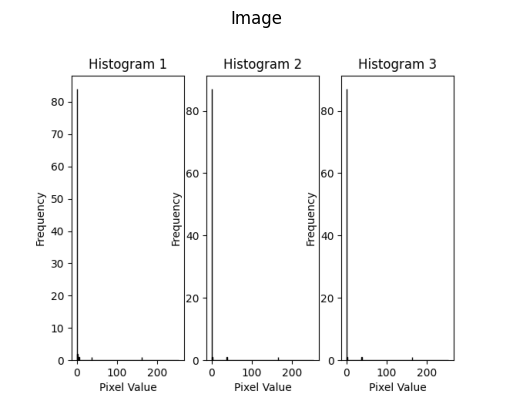

In [133]:
# Load image and and compute its histogram

# Add your code here

img = cv.imread('./data/barbecue.jpg')

hD = calc_hists(img)



img = show_histogram(hD)

plt.imshow(img)
plt.axis('off')  # Turn off axis labels and ticks
plt.title('Image')  # Set a title for the plot (optional)
#plt.show()


In [134]:
# Show the image with its histogram before the equalization

# Add your code here

In [135]:
# Equalize the histogram of the image

# Add your code here


# Show the image and the relative histogram (in the same window)

# Add your code here

### Equalize the image in the LAB space

Equalize the image (`./data/barbecue.jpg`) in the LAB space and show the result.

In [136]:
# Load the image and convert it to LAB colorspace

# Add your code here

In [137]:
# Equalize the histogram of the L channel

# Add your code here


# Convert the image back to BGR colorspace

# Add your code here


# Extract the histograms for each channel

# Add your code here

In [138]:
# Show the image and its relative histogram

# Add your code here

---

## Histogram matching

In this section you will have to perform the histogram matching of the image `./data/panorama_left.jpg` to the image `./data/panorama_right.jpg`. Do that in the **BGR** color space.

### Histogram matching function

The function to perform the histogram matching is provided here. The function takes in input the image to be matched and the image to match and will return the matched image.

In [139]:
#  function to perform the histogram matching
def hist_match(source: np.ndarray, reference: np.ndarray) -> np.ndarray:
    """
    Adjust the pixel values of a color image such that its histogram
    matches that of a target one.

    Args:
        source (numpy.ndarray): Image to transform; the histogram is computed over the flattened array
        reference (numpy.ndarray): Template image; can have different dimensions from source
    Returns:
        numpy.ndarray: The transformed output image
    """
    
     # Assert that the images have the same number of channels (grayscale or RGB) and the same dimensions
    assert source.shape[2] == reference.shape[2], "Images must have the same number of channels"
    assert source.shape[:2] == reference.shape[:2], "Images must have the same dimensions"

    # Compute the source image's histogram and CDF
    src_hists = [np.histogram(source[..., i].flatten(), 256, [0,256])[0] for i in range(source.shape[2])]
    src_cdfs = [hist.cumsum() for hist in src_hists]
    src_cdfs_normalized = [cdf / float(cdf.max()) for cdf in src_cdfs]
 
    # Compute the reference image's histogram and CDF
    ref_hists = [np.histogram(reference[..., i].flatten(), 256, [0,256])[0] for i in range(reference.shape[2])]
    ref_cdfs = [hist.cumsum() for hist in ref_hists]
    ref_cdfs_normalized = [cdf / float(cdf.max()) for cdf in ref_cdfs]

    # Create a lookup table to map pixel values from the source to the reference
    lookup_tables = [np.zeros(256) for _ in range(source.shape[2])]
    lookup_values = [0] * source.shape[2]
    for index in range(len(lookup_tables)):
        for src_pixel_val in range(len(src_cdfs_normalized[index])):
            lookup_values[index]
            for ref_pixel_val in range(len(ref_cdfs_normalized[index])):
                if ref_cdfs_normalized[index][ref_pixel_val] >= src_cdfs_normalized[index][src_pixel_val]:
                    lookup_values[index] = ref_pixel_val
                    break
            lookup_tables[index][src_pixel_val] = lookup_values[index]

    # Apply the lookup table to the source image
    matched = np.stack([cv.LUT(source[..., i], lookup_tables[i]).astype(np.uint8) for i in range(len(lookup_tables))], axis=-1)

    return matched

### Match the images

In [140]:
# Load the two iamges

# Add your code here

In [141]:
# Visualize the two images with the relative histograms
# before the histogram matching

# Add your code here

In [142]:
# Match the histograms of the two images

# Add your code here


# Visualize the two iamges with the relative histograms

# Add your code here

---

## Image denoising

In this section you will have to perform the denoising of the image ./data/overexposed.jpg. Do that using the following filters:

    Gaussian filter,
    Median filter,
    Bilateral filter.

For each filter you will have to try different values for the parameters in order to see the effect of each parameter on the result. To do that in an interactive way it is required that you implement the cv.trackbar function. In this way you will be able to change the parameters of the filters and to see the result in real time.

In order to build a better code you have to implement each filter as a class (child of a main filter class called Filter). The structure to do this is already provided in this notebook

### Define the filters classes

In [143]:
# Define the main Filter class with the common methods
# (this class will be used as a base class for the other filters)
class Filter:
    def __init__(self, size: int):
        # Constructor of the class
        if size % 2 == 0:
            size += 1
        self.set_filter_size(size)
    
    def set_filter_size(self, size: int) -> None:
        # Method to set the filter size
        if size % 2 == 0:
            size += 1
        self.filter_size = size
    
    def get_filter_size(self) -> int:
        # Method to get the filter size
        return self.filter_size

    def __call__(self, image: np.ndarray)) -> None:
        # Method to perform the filtering
        # (it must be implemented in the derived classes)
        raise NotImplementedError

SyntaxError: unmatched ')' (745883566.py, line 20)

In [ ]:
# Define the class for the gaussian filter
class GaussianFilter(Filter):
    def __init__(self, size: int, sigma_g: float):
        super().__init__(size)
        self.sigma = sigma_g

    def set_sigma(self, s: float) -> None:
        # Method to set the sigma value

        # Add your code here (remove the pass statement)
        pass

    def get_sigma(self) -> float:
        # Method to get the sigma value
        
        # Add your code here (remove the pass statement)
        pass
    
    def __call__(self, image: np.ndarray, size: int, sigma: float) -> None:
        # Method to call the filter (it is called when the object is called)
        # This function will be called by the trackbar object and will update the imamge to show
        
        # Add your code here (remove the pass statement)
        pass


# Define the class for the median filter
class MedianFilter(Filter):
    def __init__(self, size: int):
        super().__init__(size)

    def __call__(self, image: np.ndarray, size: int) -> None:
        # Method to call the filter (it is called when the object is called)
        # This function will be called by the trackbar object and will update the image to show
        
        # Add your code here (remove the pass statement)
        pass


# Define the class for the bilateral filter
class BilateralFilter(Filter):
    def __init__(self, size: int, sigma_s: float, sigma_r: float):
        super().__init__(size)
        self.sigma_space = sigma_s
        self.sigma_range = sigma_r

    def set_sigma_range(self, sr: float) -> None:
        # Method to set the sigma range value

        # Add your code here (remove the pass statement)
        pass

    def get_sigma_range(self) -> float:
        # Method to get the sigma range value
        
        # Add your code here (remove the pass statement)
        pass

    def set_sigma_space(self, ss: float) -> None:
        # Method to set the sigma space value

        # Add your code here (remove the pass statement)
        pass

    def get_sigma_space(self) -> float:
        # Method to get the sigma space value
        
        # Add your code here (remove the pass statement)
        pass
    
    def __call__(self, image: np.ndarray, sigma_s: float, sigma_r: float) -> None:
        # Method to call the filter (it is called when the object is called)
        # This function will be called by the trackbar object and will update the imamge to show
        
        # Add your code here (remove the pass statement)
        pass

### Load the image and initialize the filters objects

In [ ]:
# Load and show the image to filter

# Add your code here

In [ ]:
# Initialize the filters

# Add your code here

### Test the filters

In [ ]:
# MEDIAN BLUR FILTER


# Create a window for the trackbars

# Add your code here


# Create the trackbar

# Add your code here


# Show the filtered image with a slider to change the kernel size

# Add your code here

In [ ]:
# GAUSSIAN BLUR FILTER


# Create a window for the trackbars

# Add your code here


# Create the trackbar

# Add your code here


# Show the filtered image with a slider to change the kernel size

# Add your code here

In [ ]:
# BILATERAL FILTER


# Create a window for the trackbars

# Add your code here


# Create the trackbar




# Show the filtered image with a slider to change the kernel size

# Add your code here